<a href="https://colab.research.google.com/github/yugshah7777/SpyD_SIH/blob/Sachit/models/ARMA_ORACLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

In [7]:
from statsmodels.tsa.stattools import adfuller

In [8]:
def perform_adf_test(series, title=''):
    print(f"--- Augmented Dickey-Fuller Test on {title} ---")
    result = adfuller(series.dropna())

    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print(f'ADF Statistic: {adf_statistic:.4f}')
    print(f'p-value: {p_value:.4f}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'\t{key}: {value:.4f}')

In [9]:
end_date = datetime.now()
start_date = end_date - timedelta(days=365*2)
tickerSymbol = 'ORCL'
data = yf.Ticker(tickerSymbol)

prices = data.history(start=start_date, end=end_date).Close
returns = prices.pct_change().dropna()

print(returns.head())

Date
2023-10-03 00:00:00-04:00   -0.020523
2023-10-04 00:00:00-04:00    0.024493
2023-10-05 00:00:00-04:00    0.011860
2023-10-06 00:00:00-04:00    0.014859
2023-10-09 00:00:00-04:00    0.003274
Name: Close, dtype: float64


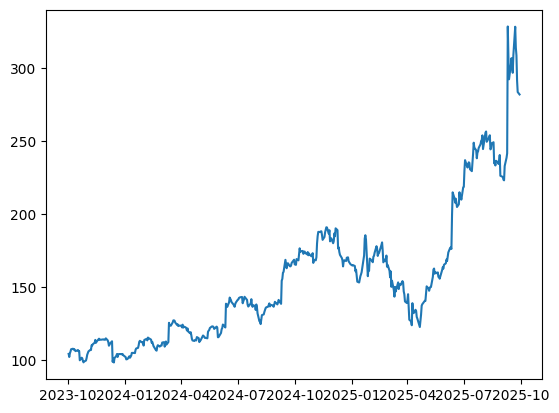

In [10]:
plt.plot(prices)
plt.show()

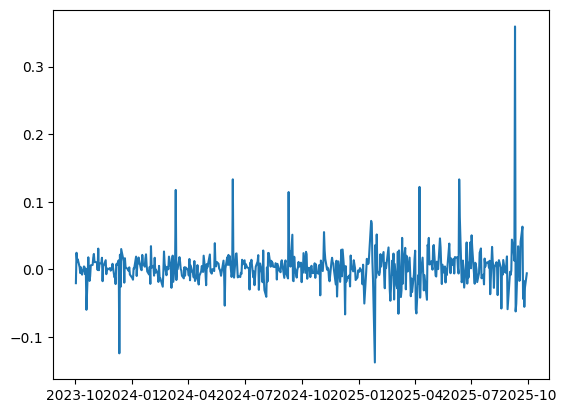

In [11]:
plt.plot(returns)
plt.show()

In [12]:
perform_adf_test(prices, title='Raw Stock Prices') #p value comes out to be 0.5048, easily non stationary

--- Augmented Dickey-Fuller Test on Raw Stock Prices ---
ADF Statistic: 0.7064
p-value: 0.9900
Critical Values:
	1%: -3.4439
	5%: -2.8675
	10%: -2.5700


In [13]:
perform_adf_test(returns, title='Daily Returns') #p value comes out to be 0.0000 so it is safe to say that it is stationary

--- Augmented Dickey-Fuller Test on Daily Returns ---
ADF Statistic: -23.2617
p-value: 0.0000
Critical Values:
	1%: -3.4435
	5%: -2.8674
	10%: -2.5699


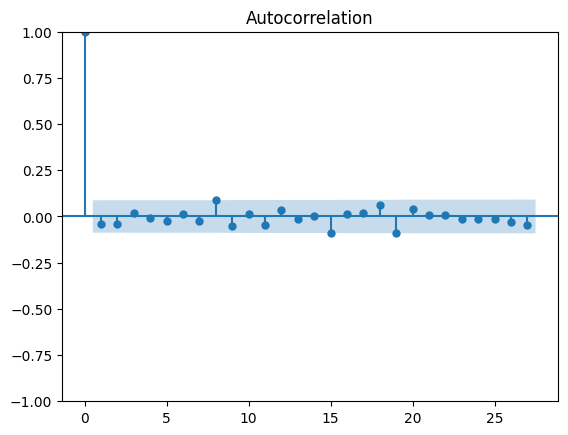

In [14]:
plot_acf(returns)
plt.show()

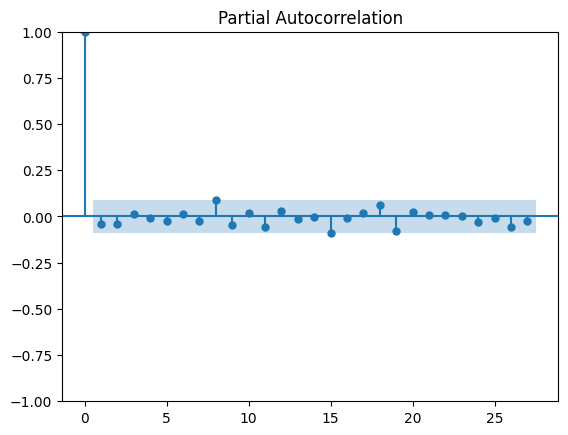

In [15]:
plot_pacf(returns)
plt.show()

In [16]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None

    curr_holding = False
    events_list = []
    init_amt = amt

    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))

            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        curr_data = returns[:date]

        if type(order) == tuple:
            try:
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order)
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):

            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)

    if verbose:
        print('Total Amount: $%s'%round(amt,2))


    if plot:

        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims),
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()

    return amt

100%|██████████| 485/485 [00:00<00:00, 7346.73it/s]


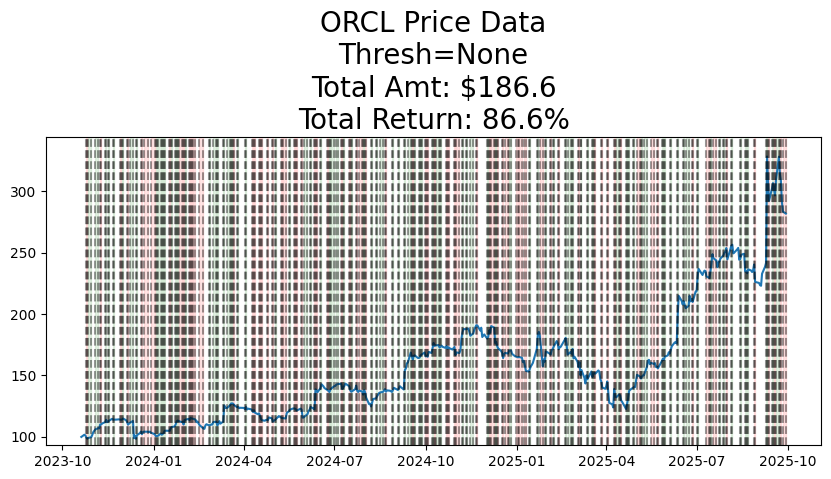

np.float64(186.5983668816951)

In [17]:
run_simulation(returns, prices, 100, 0.5, None, verbose=False)

WE GOT a profit of 7 dollars by randomly buying and selling... in this Iteration

In [18]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

100%|██████████| 485/485 [00:00<00:00, 14641.33it/s]


/tmp/ipython-input-2783033276.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_amts)


Text(0.5, 1.0, 'Avg: $147.21\nSD: $44.2')

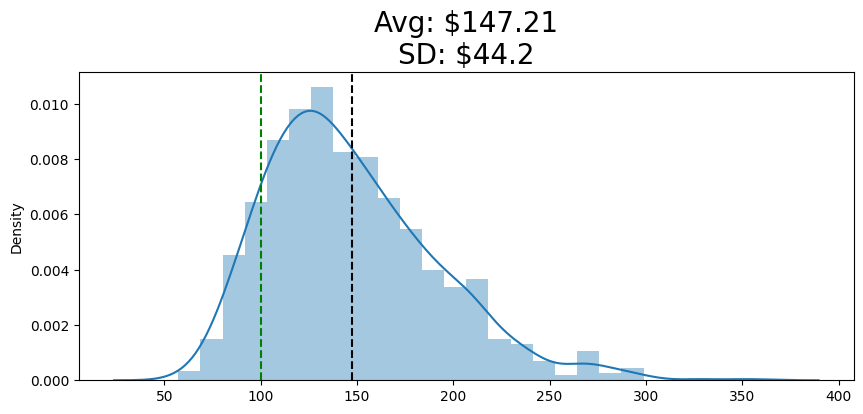

In [19]:
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

EXPLANATION
apple stock price has shown upward trend over last 2 years therefore it is giving a +ve value overall



In [20]:
from statsmodels.tsa.arima.model import ARIMA

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Training data size: 478
Testing data size: 21


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



Static Forecast Model Performance
Root Mean Squared Error (RMSE): $48.11
Mean Absolute Percentage Error (MAPE): 14.01%



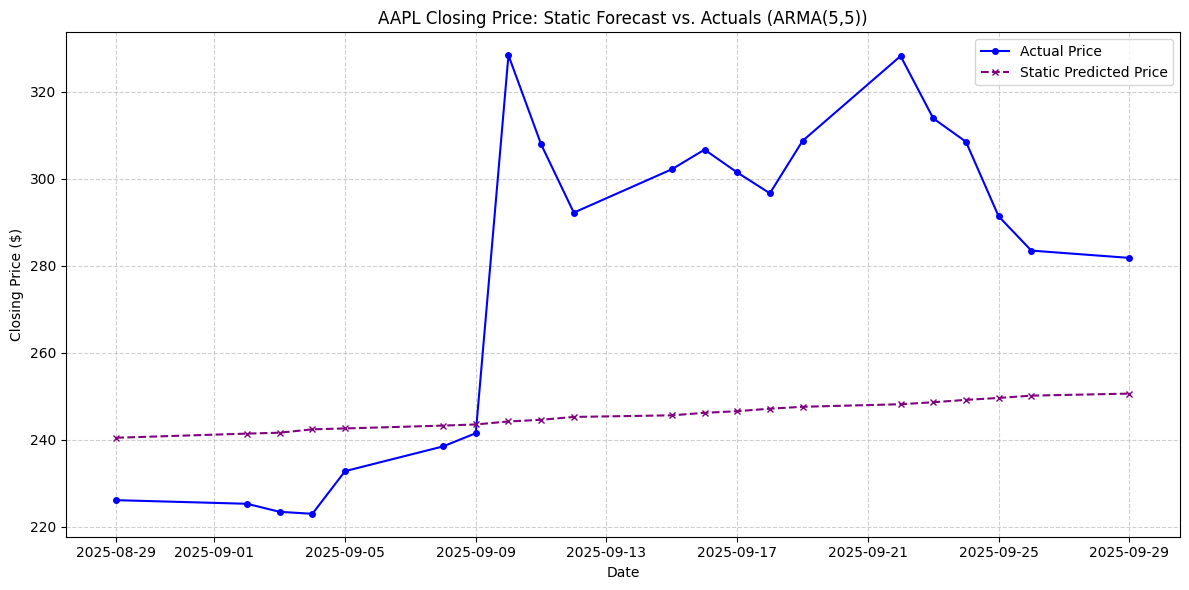

In [39]:
split_size = 21
train_data, test_data = returns[:-split_size], prices[-split_size:]

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")
model = ARIMA(train_data, order=(5, 0, 5))
model_fit = model.fit()
predicted_returns = model_fit.forecast(steps=len(test_data))
predictions_price = []
last_actual_price = prices.iloc[-split_size-1]
for predicted_return in predicted_returns:
    predicted_price = last_actual_price * (1 + predicted_return)
    predictions_price.append(predicted_price)
    last_actual_price = predicted_price

predictions_series = pd.Series(predictions_price, index=test_data.index)
print("\n" + "="*30)
print("Static Forecast Model Performance")
print("="*30)

actual = test_data
predicted = predictions_series
rmse = np.sqrt(np.mean((predicted - actual)**2))
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print("="*30 + "\n")

plt.figure(figsize=(12, 6))
plt.plot(actual.index, actual, label='Actual Price', color='blue', marker='o', markersize=4)
plt.plot(predicted.index, predicted, label='Static Predicted Price', color='purple', linestyle='--', marker='x', markersize=4)
plt.title('AAPL Closing Price: Static Forecast vs. Actuals (ARMA(5,5))')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [64]:
split_size = 21
train_data, test_data = returns[:-split_size], prices[-split_size:]

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")
print("-" * 30)
history = train_data.tolist()
predictions_price = []
for t in tqdm(range(len(test_data)), desc="Forecasting Progress"):
    model = ARIMA(history, order=(5, 0, 5))

    try:
        model_fit = model.fit()
        predicted_return = model_fit.forecast()[0]
        if t == 0:
            last_price = prices.iloc[-split_size - 1]
        else:
            last_price = predictions_price[-1]

        predicted_price = last_price * (1 + predicted_return)
        predictions_price.append(predicted_price)
        history.append(predicted_return)

    except Exception as e:
        print(f"An error occurred at step {t}: {e}")
        history.append(0)
        if predictions_price:
             predictions_price.append(predictions_price[-1])
        else:
             predictions_price.append(prices.iloc[-split_size -1])

Training data size: 478
Testing data size: 21
------------------------------


Forecasting Progress:   0%|          | 0/21 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Forecasting Progress:   5%|▍         | 1/21 [00:08<02:41,  8.06s/it]/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

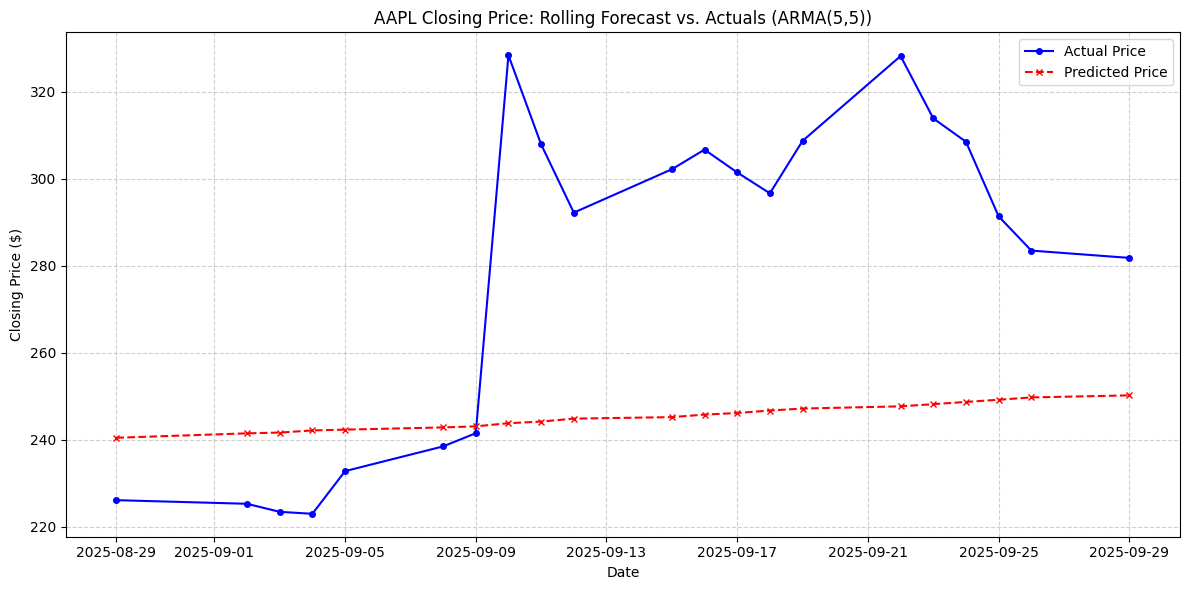

In [65]:
predictions_series = pd.Series(predictions_price, index=test_data.index)

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Price', color='blue', marker='o', markersize=4)
plt.plot(predictions_series.index, predictions_series, label='Predicted Price', color='red', linestyle='--', marker='x', markersize=4)
plt.title('AAPL Closing Price: Rolling Forecast vs. Actuals (ARMA(5,5))')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [66]:
actual = test_data
predicted = predictions_series

In [67]:
rmse = np.sqrt(np.mean((predicted - actual)**2))
print(f"{rmse:.2f}")

48.43


In [68]:
mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"{mape:.2f}%")

14.08%
